**Install dependencies:** In case this notebook is not running [Carto-Lab Docker](https://cartolab.theplink.org/), the cell below aims to install the needed packages for this notebook. If packages are already available, they will be ignored.

In [17]:
import sys
pyexec = sys.executable
print(f"Current Kernel {pyexec}")
!../py/modules/pkginstall.sh "{pyexec}" owslib contextily geopandas matplotlib mapclassify adjustText cartopy geoviews

Current Kernel /opt/conda/envs/worker_env/bin/python3.13
owslib already installed (version 0.34.0).
contextily already installed (version 1.6.2).
geopandas already installed (version 1.0.1).
matplotlib already installed (version 3.10.1).
mapclassify already installed (version 2.8.1).
adjustText already installed (version 1.3.0).
cartopy already installed (version 0.24.0).
geoviews already installed (version 1.14.0).


(content:references:datasetupreferencedocs)=
(content:references:explitanchor)=
# Accessing Data

**Reproducibility and Data Retrieval**

In data analysis and processing, **reproducibility** is paramount. It means anyone should be able to arrive at the same results by following your steps. Traditional GIS workflows often rely on manual steps: opening a browser, navigating to a website, clicking download links, manually unzipping files, and organizing them into folders. While this gets the job done for a single instance, it creates a "black box" – it's incredibly difficult to document precisely *how* the data was acquired or for others to replicate the exact process. Using a programmatic approach, as we will in this book, allows us to embed data retrieval steps directly into our scripts. By documenting the data source URLs, expected filenames, and extraction logic within the code itself, we create a clear, executable record that makes your work fully reproducible and easily shareable. We begin by demonstrating this process.

```{admonition} Summary
:class: hint

This section outlines common methods for accessing data within a Python environment, whether it's local files, data from APIs, or Web Feature Services (WFS).
```

## Accessing remote files

```{admonition} Required step
:class: warning

The following command retrieves and sets up the base data required for all notebooks in the Reference Documentation chapter.
```

Following the principles of reproducibility, the code block below automates the necessary first step: acquiring the data. Instead of requiring you to manually open a web browser, navigate to a URL, click a download link, then find the downloaded zip file and unzip it, this script handles everything programmatically. The script uses the `requests` library, but we placed this in a separate module, so it can be reused in other notebooks.

In [18]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools

INPUT = Path.cwd().parents[0] / "00_data"
INPUT.mkdir(exist_ok=True)

if not Path(INPUT / "Biotopwerte_Dresden_2018.gdb.zip").exists():
    tools.get_zip_extract(
        output_path=INPUT,
        uri_filename="https://datashare.tu-dresden.de/s/KEL6bZMn6GegEW4/download")

Loaded 48.03 MB of 48.04 (100%)..
Extracting zip..
Retrieved download, extracted size: 246.41 MB


The script first sets up paths to locate our custom utility modules and the designated data directory (`00_data`). It then performs a check: `if not Path(...).exists():`. This is an important efficiency measure; it verifies if the expected zip file (`Biotopwerte_Dresden_2018.gdb.zip`) already exists in the target location. If the file is *not* found, the download process is triggered.

This process is handled by a function `get_zip_extract` from our custom `tools` module (`tools.get_zip_extract`). This module encapsulates the logic for downloading data from a given URL (like the one provided via `uri_filename`) and automatically unzipping its contents into the specified `output_path`. By wrapping this functionality in a reusable module, we keep the main notebook code clean and ensure that the data retrieval process is consistent and easily invoked across different parts of our project, all while being fully documented within the script itself, which is shared together with notebooks in the git repository.

### Further Extraction

The zip file we downloaded and extracted includes two more zip files (nested). To further extract contents from these zip files (`Biotopwerte_Dresden_2018.gdb.zip`, `Biotopwert_Biodiversität.zip`), we directly use Python's `zipfile` package below. 

- The variable `INPUT` is a `Path` object pointing to your target data directory (`00_data`).
- By constructing the path `INPUT / "Biotopwerte_Dresden_2018.gdb.zip"`, we ensure the zip file is located correctly,
- and `extractall(INPUT)` extracts its contents **directly into the directory specified by `INPUT`**, regardless of the notebook's current working directory.
- we do this in a `for .. in ..` loop for all files in the `zip_files` list

In [19]:
import os, zipfile

zip_files = ["Biotopwerte_Dresden_2018.gdb.zip", "Biotopwert_Biodiversität.zip"]

for zip_file in zip_files:
    zip_path = INPUT / zip_file
    zipfile.ZipFile(zip_path, 'r').extractall(INPUT)

This includes an ESRI GeoDataBase with biotope data that we use as an example in the reference documentation.

## Accessing local files

### Understanding file paths

Data is frequently stored in files on your computer or accessible through your local environment. Depending on where your Python code is executed (your local machine, a remote server, or a cloud platform like JupyterLab), `local` can have different meanings. Data is accessed using file paths.

There are two main types of file paths:

**Absolute file paths**

Specify the exact location of a file or directory, starting from the root of the file system. Common formats in Python include:

- Double backslashes (`\\`) → `"C:\\Users\\file.json"`
- Raw string (prefix with `r`) → `r"C:\Users\file.json"`
- Forward slashes (`/`) → `"C:/Users/file.json"`

`````{admonition} Note
:class: note
In Python, single backslashes (`\`) are treated as [escape characters](https://en.wikipedia.org/wiki/Escape_character), which is why using double backslashes (`\\`) or a raw string (`r""`) is necessary to avoid errors.
`````

**Relative file path**

Specify the location of a file or directory relative to the current working directory (the folder where your Python script or Jupyter Notebook is running).

### Working with file paths using `pathlib`

Use Python's [pathlib](https://docs.python.org/3/library/pathlib.html) to write code that works on any operating system, whether it's Windows, Mac, or Linux. This module simplifies file and folder management by providing a consistent, structured approach. By using pathlib, your code becomes more portable, allowing colleagues on different systems to run it without path modification and reproduce your results.

Here is a example how the code with `pathlib` can look like (we already used this code below):

In [20]:
from pathlib import Path

base_path = Path.cwd().parents[0]
INPUT = base_path / "00_data" # refers to the folder path named "00_data"
INPUT.mkdir(exist_ok=True) # creates the "00_data" folder if it doesn't already exist.

Explainations:
- `Path.cwd()` → Gets the current working directory (cwd), which is the folder where your Jupyter Notebook or Python script is running.
- `.parents[0]` → moves one level up from the current working directory.

### Defining parameters as constants

It's a good practice to define key parameters, such as important file paths, at the beginning of your Jupyter Notebook or Python script. Using uppercase variable names (constants) makes them easily identifiable and modifiable.

Using constants in a Python script or Jupyter Notebook helps to:

- Reuse frequently used variables that should not change.
- Make key parameters easy to find and modify.
- Follows a common Python naming convention.

Example using constants and `pathlib`

In [21]:
from pathlib import Path

# Defining constants at the top of the notebook

base_path = Path.cwd().parents[0]  # Moves one level up from the notebook / folder
OUTPUT = base_path / "out"         # Directory for saving outputs
WORK_DIR = base_path / "tmp"       # Working directory

In [22]:
# Example of defining a specific data file path using the INPUT_DIR constant
current_path = Path.cwd()
mydata = current_path.parents[0] / "00_data" / "Biotopwerte_Dresden_2028.geojson"

Since the `INPUT` already defined above, this can be shortened to:

In [23]:
mydata = INPUT / "Biotopwerte_Dresden_2028.geojson"

### Handling compatibility with older libraries

Some older Python libraries might not directly support `pathlib` objects. In such cases, you can easily convert a `Path` object to its string representation using `str()` (e.g. `str(mydata)`). 

You can use the Jupyter `?` to inspect the type of a variable:

In [24]:
?mydata

Type:        PosixPath
String form: /home/jovyan/work/jupyter-book-nfdi4biodiversity/00_data/Biotopwerte_Dresden_2028.geojson
File:        /opt/conda/envs/worker_env/lib/python3.13/pathlib/_local.py
Docstring:  
Path subclass for non-Windows systems.

On a POSIX system, instantiating a Path should return this object.

## Accessing Data from an Application Programming Interface (API) or URL

Application Programming Interfaces (APIs) provide a way to retrieve data from web servers. The `request` package is commonly used in Python to interact with URL-based APIs.

In [25]:
import requests

# Define the API endpoint URL
url="https://datashare.tu-dresden.de/s/wt5CGqWL36sBSx6/download"

# Send a GET request to the API
response = requests.get(url)

# Based on the format of the data in the API, the response should be converted. 
# To find out the response format, check the `Content Type`.
print(response.headers["Content-Type"])

# In the following example, it converts the response of JSON format 
# to a Python data structure and the data stored in a data variable api_data.
api_data = response.json()

application/octet-stream


Get information about the response object. In this case, the json is available as a Python dictionary.

In [26]:
?api_data

Type:        dict
String form: {'displayFieldName': '', 'fieldAliases': {'FID': 'FID', 'CLC_st1': 'CLC_st1', 'Biotpkt201': 'Biot <...> 00045, 5665027.2312], [417600.4868999999, 5665023.1954], [417482.89749999996, 5665014.0482]]]}}]}
Length:      6
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

## Accessing data via Web Feature Service (WFS)

Web Feature Service (WFS) is a standard protocol for serving geographic features over the internet. Many government and open data portals, like the [Dresden Opendata Portal](https://opendata.dresden.de/), provide data through WFS. For instance, the WFS for Dresden`s city districts (Stadtteile) can be found [here](https://opendata.dresden.de/informationsportal/?open=1&result=493101D03C794E9C99CD8B2BAC194FEC#app/mainpage////).

**Example of accessing data from a WFS**:

Load the dependencies first.

In [27]:
from io import BytesIO
from urllib.parse import urlencode
# packages:
import contextily as cx
import geopandas as gp
import pandas as pd
import requests
from owslib.wfs import WebFeatureService
import matplotlib.pyplot as plt

Before accessing the data, the layer name is required. To extract the layer name, the node-id should be defined which is mentioned in the [WFS URL](https://kommisdd.dresden.de/net3/public/ogcsl.ashx?nodeid=188&service=wfs&request=getcapabilities).

In [28]:
# Define the base WFS URL for the Dresden Opendata Portal
topics_dd = "https://kommisdd.dresden.de/net3/public/ogcsl.ashx"

# Define parameters to specify the desired WFS service
params = {
    "nodeid": 188, # Node ID for the specific dataset
    "service": "wfs",
}
wfs_url = f"{topics_dd}?{urlencode(params)}"

wfs = WebFeatureService(url=wfs_url, version='2.0.0')

# List available layer names
layer_names_df = pd.DataFrame(wfs.contents.keys(), columns=["Layer Name"])
print("Available WFS Layers:")
print(layer_names_df)

Available WFS Layers:
  Layer Name
0   cls:L137


To get the first layer name directly the [0] is used.

In [29]:
layer_name = list(wfs.contents.keys())[0]

Next, a function is written to request features for the layer, using the `requests` library. This will also turn features into a Geopandas GeoDataFrame, which is a suitable spatial data format in Python.

In [30]:
def wfs2gp(layer_name, url):
    """Request a WFS feature layer (layer_name) and turn into GeoDataFrame"""
    params = {
        'service': 'WFS',
        'version': '2.0.0',
        'request': 'GetFeature',
        'TYPENAMES': layer_name,
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
       raise Exception(f"Error fetching data: {response.status_code} {response.text}")
    return gp.read_file(BytesIO(response.content))

gdf = wfs2gp(layer_name, wfs_url)

Have a peek at the returned data.

In [31]:
gdf.head(2)

,gml_id,blocknr,bez,bez_lang,flaeche_km2,sst,sst_klar,historie,aend,geometry
0,L137.02,02,Pirnaische Vorstadt,Pirnaische Vorstadt,0.9281,None,None,akt,2025-03-20T00:00:00,"POLYGON ((412388.19 5655704.138, 412401.414 56..."
1,L137.53,53,Striesen-Süd,Striesen-Süd mit Johannstadt-Südost,1.3276,None,None,akt,2025-03-20T00:00:00,"POLYGON ((414167.951 5655584.522, 414158.22 56..."


... and plot a map, which is explained in more detail in the [Creating Maps Chapter](https://stag.hack.conference.ioer.info/notebooks/305_mapping.html#creating-maps).

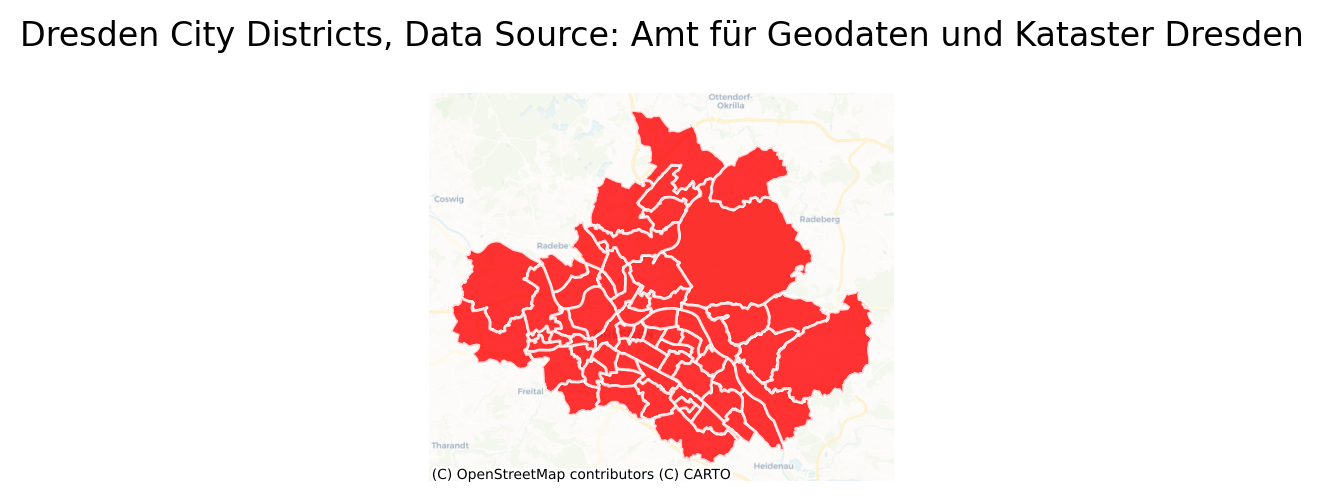

In [32]:
CRS_PROJ = "epsg:3857"

gdf.to_crs(CRS_PROJ, inplace=True)
fig, ax = plt.subplots(figsize=(3, 7), dpi=200)
ax = gdf.plot(
    ax=ax,
    alpha=0.8,
    linewidth=1,
    edgecolor="white",
    facecolor="red",
    markersize=300)
cx.add_basemap(
    ax, alpha=0.5,
    source=cx.providers.CartoDB.Voyager,
    attribution_size=5)
ax.set_title("Dresden City Districts, Data Source: Amt für Geodaten und Kataster Dresden")
# turn of axes display
ax.set_axis_off()

```{admonition} Query a different nodeid!
:class: dropdown, attention
You can replace "nodeid" with any other WFS Data Source from the Dresden Opendata Portal. Update the nodeid and re-run the code above to see the different data rendered.
```